# 532 Lec 4 - Deployment on Heroku and maps in Altair

You need to download this notebook to view images.

## Lecture learning goals

By the end of the lecture you will be able to:


1. Setup and Heroku account and run the Heroku CLI
2. Prepare the necessary files for deployment
3. Push to Heroku's repo and troubleshoot remote errors
4. Work with geojson and topojson files
5. Create maps in Altair with interactivity

## Table of Contents

You can view the ToC by opening this in your local Jupyter Lab,
and downloading the ToC extension
by going to the Extension Manager tab in the left sidebar, searching for "toc", and clicking "install"
(I posted [a video about this on slack](https://ubc-mds.slack.com/archives/C24GEJS11/p1599940203406600) if you can't find the extension).

# Deployment with Heroku

Deploying our app essentially means everything we need to do 
in order for it to become available for others to use.
For our dashboard,
this entails uploading our code to a computer that is always running
and has a web server so that other people can visit it.
On this web server,
we need to install all the required Python packages for our app,
and then run it via the same command we use on our computer.

Luckily,
we don't have to do these steps manually.
We're going to use the Heroku web service,
that will take care of most of these steps for us,
after we have set up a few configuration files.
Similar to how GitHub actions and tests can run as soon as you make your PR,
Heroku will build our app and start the Python server
as soon as we upload our code.

As an overview, this is what Heroku does:

1. New code is pushed to heroku's git repo.
2. Heroku installs the packages in `requirements.txt`.
3. Heroku runs whatever line you have in `Procfile`
   (in our case to serve your app on the web, but it could be other things).

Let's get going!

The first step is to get an account at https://www.heroku.com/,
and for this lab,
you can create a common account that all of you share,
or have one dedicated person doing the deployment
(but it is good to have at least one backup person!).
Heroku provides us with unix web servers configured to run apps in Python
and other languages,
so that we don't have to worry about building them ourselves.

The second step is to [download the heroku CLI](https://devcenter.heroku.com/articles/getting-started-with-python#set-up)
and login with your credentials of the account you just created
by typing `heroku login` at the command line.
Then we are going to [follow the dash deployment guide](https://dash.plotly.com/deployment)
(scroll down to the Heroku section),
but skip all the steps related to virtualenv
(and the gitignore part is optional),
details below.
If some of the concepts below sound confusing and you want to learn more,
[this is a good writeup](https://towardsdatascience.com/deploying-your-dash-app-to-heroku-the-magical-guide-39bd6a0c586c)
although it does not follow exactly the same steps as we do.

## Pip

Heroku uses `pip` instead of `conda` to install dependencies,
so we will need to create a `requirements.txt` file to control what Heroku will install.
Instead of doing this via `pip freeze`,
it is recommended that you create `requirements.txt` manually,
to avoid that you get a lot of conda-specific packages included that we don't need,
and that can't be installed via `pip`.
The requirements file has either just the `package-name` or `package-name==version-number`,
and could look like this for your app:

```
pandas
gunicorn
altair
dash==1.18.1
dash_bootstrap_components
plotly==4.14.3
```

## gunicorn

You need to include the `gunicorn` library even though you don't use it locally.
`gunicorn` is a HTTP server specifically for Python web applications which runs natively in Unix.
You also need to create a `Procfile` which tells Heroku
where your main app file is located and that you want to use `gunicorn` to run it.
This line will work if it is in `src/app.py`:

```
web: gunicorn src.app:server
```

If you have issues with performance,
you can try running `gunicorn` with more workers (`-w num`) or threads (`--threads num`), but the dash docs recommends the line we have above. The [`gunicorn` docs reccommend this formula](https://docs.gunicorn.org/en/latest/design.html#how-many-workers): `2x <num_cores> + 1`. I believe that the free heroku tier dynos has 4 cores, but they are shared with other users, so maybe try with `-w 4` if you want to experiment with performance.

The final modification we need to make,
is to define the variable `server` in our `app.py`.
The name is a convention
for what `gunicorn` will run (src.app:**server**).
So we need to add this line anywhere in `app.py`
(conventionally just below `app = dash.Dash(...)`,
see the example in the dash deployment docs for reference if this is unclear).

```
server = app.server
```

## Push and deploy!

Almost there!
The rest is following steps 4 and 5 in the heroku deployment guide:


```bash
heroku create my-dash-app # change my-dash-app to a unique name
git add . # add the files you need to git
git commit -m 'Initial app boilerplate'
git push heroku master # deploy code to the heroku repos master branch
```

If you are prompted to login when pushing, 
use `heroku login` instead of typing your credentials to git.
When you push,
heroku will automatically start building your app,
let it finish and look out for errors.
Then run the following,
to start one "dyno" (unix machine)
for your app.

```
heroku ps:scale web=1  # run the app with a 1 heroku "dyno"
```

Navigate to the URL heroku gave you
(you can also type `heroku open`).
YOU DID IT!!!!! :raise_hands:

If your app fails to launch,
you can check what went wrong via `heroku logs --tail`.
Usually you forgot to include some package in the requirements file
(like I did twice while writing these notes...).

When you make changes to your app,
you need to follow add and commit it to github 
and then push to heroku again,
so it rebuilds your app.

Your app might be slow on first launch,
after a while of activity because your server it stopped
to ssave costs unless you pay for an account:

> By default, your app is deployed on a free dyno. Free dynos will sleep after a half hour of inactivity (if they don’t receive any traffic). This causes a delay of a few seconds for the first request upon waking. Subsequent requests will perform normally. Free dynos also consume from a monthly, account-level quota of free dyno hours - as long as the quota is not exhausted, all free apps can continue to run
>
> https://devcenter.heroku.com/articles/free-dyno-hours#usage

You have about 500 free hours per month, which is plenty for one app.

# Geographic Data: GeoJSON and TopoJSON

*This first half of this geo section is taken from 
https://github.com/uwdata/visualization-curriculum with minor modifications.*

Up to this point, we have worked with JSON and CSV formatted datasets that correspond to data tables made up of rows (records) and columns (fields). In order to represent geographic regions (countries, states, _etc._) and trajectories (flight paths, subway lines, _etc._), we need to expand our repertoire with additional formats designed to support rich geometries.

[GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) models geographic features within a specialized JSON format. A GeoJSON `feature` can include geometric data &ndash; such as `longitude`, `latitude` coordinates that make up a country boundary &ndash; as well as additional data attributes.

Here is a GeoJSON `feature` object for the boundary of the U.S. state of Colorado:

~~~ json
{
  "type": "Feature",
  "id": 8,
  "properties": {"name": "Colorado"},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [[-106.32056285448942,40.998675790862656],[-106.19134826714341,40.99813863734313],[-105.27607827344248,40.99813863734313],[-104.9422739227986,40.99813863734313],[-104.05212898774828,41.00136155846029],[-103.57475287338661,41.00189871197981],[-103.38093099236758,41.00189871197981],[-102.65589358559272,41.00189871197981],[-102.62000064466328,41.00189871197981],[-102.052892177978,41.00189871197981],[-102.052892177978,40.74889940428302],[-102.052892177978,40.69733266640851],[-102.052892177978,40.44003613055551],[-102.052892177978,40.3492571857556],[-102.052892177978,40.00333031918079],[-102.04930288388505,39.57414465707943],[-102.04930288388505,39.56823596836465],[-102.0457135897921,39.1331416175485],[-102.0457135897921,39.0466599009048],[-102.0457135897921,38.69751011321283],[-102.0457135897921,38.61478847120581],[-102.0457135897921,38.268861604631],[-102.0457135897921,38.262415762396685],[-102.04212429569915,37.738153927339205],[-102.04212429569915,37.64415206142214],[-102.04212429569915,37.38900413964724],[-102.04212429569915,36.99365914927603],[-103.00046581851544,37.00010499151034],[-103.08660887674611,37.00010499151034],[-104.00905745863294,36.99580776335414],[-105.15404227428235,36.995270609834606],[-105.2222388620483,36.995270609834606],[-105.7175614468747,36.99580776335414],[-106.00829426840322,36.995270609834606],[-106.47490250048605,36.99365914927603],[-107.4224761410235,37.00010499151034],[-107.48349414060355,37.00010499151034],[-108.38081766383978,36.99903068447129],[-109.04483707103458,36.99903068447129],[-109.04483707103458,37.484617466122884],[-109.04124777694163,37.88049961001363],[-109.04124777694163,38.15283644441336],[-109.05919424740635,38.49983761802722],[-109.05201565922046,39.36680339854235],[-109.05201565922046,39.49786885730673],[-109.05201565922046,39.66062637372313],[-109.05201565922046,40.22248895514744],[-109.05201565922046,40.653823231326896],[-109.05201565922046,41.000287251421234],[-107.91779872584989,41.00189871197981],[-107.3183866123281,41.00297301901887],[-106.85895696843116,41.00189871197981],[-106.32056285448942,40.998675790862656]]
    ]
  }
}
~~~

The `feature` includes a `properties` object, which can include any number of data fields, plus a `geometry` object, which in this case contains a single polygon that consists of `[longitude, latitude]` coordinates for the state boundary.

To learn more about the nitty-gritty details of GeoJSON, see the [official GeoJSON specification](http://geojson.org/) or read [Tom MacWright's helpful primer](https://macwright.org/2015/03/23/geojson-second-bite).

One drawback of GeoJSON as a storage format is that it can be redundant, resulting in larger file sizes. Consider: Colorado shares boundaries with six other states (seven if you include the corner touching Arizona). Instead of using separate, overlapping coordinate lists for each of those states, a more compact approach is to encode shared borders only once, representing the _topology_ of geographic regions. Fortunately, this is precisely what the [TopoJSON](https://github.com/topojson/topojson/blob/master/README.md) format does!

There is a list of There is a list of Countries often make geojson
Countries often make geojson

Let's load a TopoJSON file of world countries (at 110 meter resolution):

In [1]:
import altair as alt
from vega_datasets import data


alt.renderers.enable('mimetype')

world = data.world_110m()
# This is a large dictionary so we don't want to print out all the values
world.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [2]:
world['objects'].keys()

dict_keys(['land', 'countries'])

In the data above, the `objects` property indicates the named elements we can extract from the data: geometries for all `countries`, or a single polygon representing all `land` on Earth. Either of these can be unpacked to GeoJSON data we can then visualize.

As TopoJSON is a specialized format, we need to instruct Altair to parse the TopoJSON format, indicating which named faeture object we wish to extract from the topology. The following code indicates that we want to extract GeoJSON features from the `world` dataset for the `countries` object:

In [3]:
# We need to use the url that points to the json format, not the dictionary
world_map = alt.topo_feature(data.world_110m.url, 'countries')
world_map

UrlData({
  format: TopoDataFormat({
    feature: 'countries',
    type: 'topojson'
  }),
  url: 'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/world-110m.json'
})

Now that we can load geographic data, we're ready to start making maps!

## Geoshape Marks

To visualize geographic data, Altair provides the `geoshape` mark type. To create a basic map, we can create a `geoshape` mark and pass it our TopoJSON data, which is then unpacked into GeoJSON features, one for each country of the world:

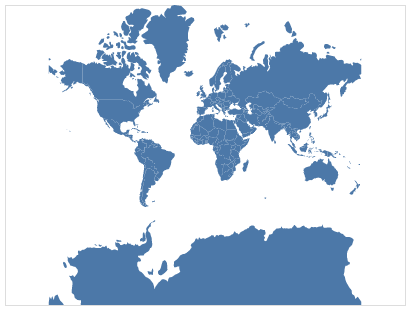

In [4]:
# alt.Chart(alt.topo_feature(data.world_110m()['objects']['caountries']['geometries']).mark_geoshape()
# alt.Chart(alt.Data(values=data.world_110m())).mark_geoshape()
alt.Chart(world_map).mark_geoshape()

In the example above, Altair applies a default blue color and uses a default map projection (`mercator`). We can customize the colors and boundary stroke widths using standard mark properties. Using the `project` method we can also add our own map projection ([there are many interesting map projections](https://en.wikipedia.org/wiki/List_of_map_projections)):

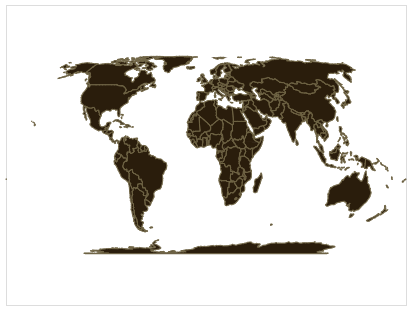

In [5]:
# https://en.wikipedia.org/wiki/Equal_Earth_projection
alt.Chart(world_map).mark_geoshape(
    fill='#2a1d0c', stroke='#706545', strokeWidth=1
).project(type='equalEarth')

By default Altair automatically adjusts the projection so that all the data fits within the width and height of the chart. We can also specify projection parameters, such as `scale` (zoom level) and `translate` (panning), to customize the projection settings. Here we adjust the `scale` and `translate` parameters to focus on Europe:

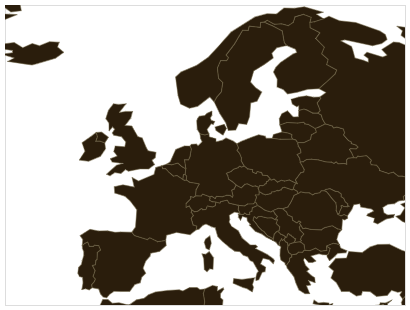

In [6]:
alt.Chart(world_map).mark_geoshape(
    fill='#2a1d0c', stroke='#706545', strokeWidth=0.5
).project(type='naturalEarth1', scale=500, translate=[140, 610])

If we want information on regions within a country,
we have to use a geo/topojson file that contains this info.
There is already one in the vega demo datasets for the US,
so let's use that one.

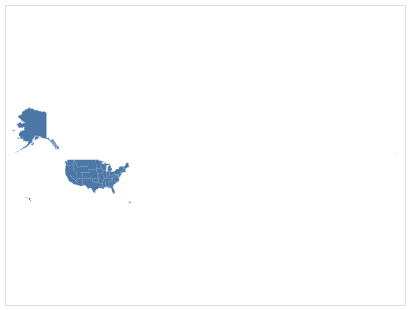

In [7]:
state_map = alt.topo_feature(data.us_10m.url, 'states')

alt.Chart(state_map).mark_geoshape()

This is not too useful on its own,
it is very small and both Alaska and Hawaii 
are shown far away from the rest of the US.
There is a special projection of America
that is more ideal when only showing this country.

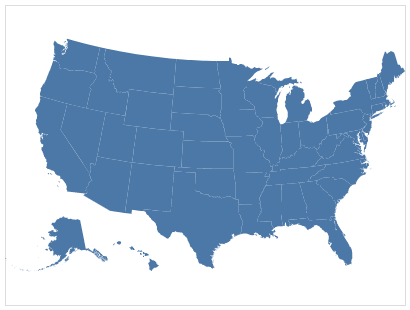

In [8]:
alt.Chart(state_map).mark_geoshape().project(type='albersUsa')

That looks better!

We could make this into a heatmap
by encoding the color to be a variable from the geojson.
If we inspected the geojson table,
we would find that it does contain the ID of each state
in alphabetical order,
so let's use this for demo purposes.
Because we are not using a pandas df,
we mush specify the type of data in the column.

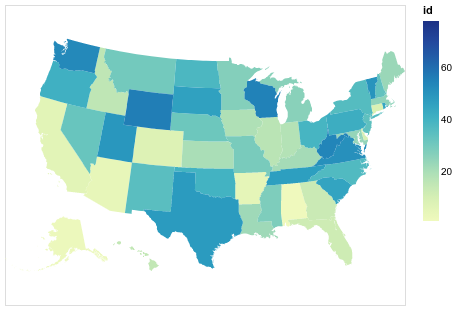

In [9]:
(alt.Chart(state_map).mark_geoshape().encode(
    color='id:Q')
.project(type='albersUsa'))

This type of geographical heatmap is called a choropleth,
and we will learn more about it later in this lecture.
To color NANs in grey instead melting together with the background,
see these links:

- https://stackoverflow.com/questions/59223458/alt-condition-not-working-for-choropleth-missing-values-n-a
- https://stackoverflow.com/questions/55229651/dealing-with-missing-values-nulls-in-altair-choropleth-map
- https://stackoverflow.com/questions/58698545/can-you-add-a-label-for-missing-data-to-a-legend-for-an-altair-chart

## Linking datasets together via lookups

Although any arbitrary information could be put in a geojson file,
they often only contain spatial coordinates
and we need to link any variables of interest from another data set
together with the json file.

For example,
we might have this table with the population for each state.

In [10]:
state_pop = data.population_engineers_hurricanes()[['state', 'id', 'population']]
state_pop[:5]

,state,id,population
0,Alabama,1,4863300
1,Alaska,2,741894
2,Arizona,4,6931071
3,Arkansas,5,2988248
4,California,6,39250017


So how do we link these two tables together?
We could do it manually,
possibly by using geopandas,
but Altair also allows us to do it in the plot call itself
by *looking up* the data in the other dataset
via a shared key column.
We have ID in alphabetical order,
just like the geojson so let's use this as the common column in the lookup.
The columns we want to fetch from the dataframe are passed in a list,
here it is only the population.

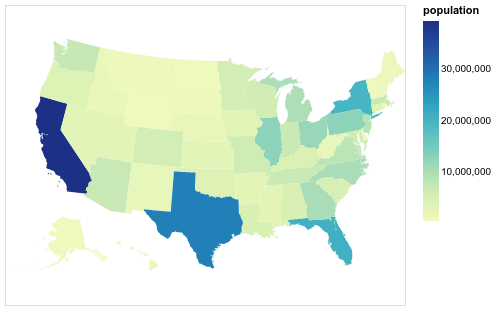

In [11]:
(alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population']))
.encode(color='population:Q')
.project(type='albersUsa'))

The `transform_lookup` is [a one sided join similar to `pd.merge(how='left')`,
which you can read more about in the Altair docs](https://altair-viz.github.io/user_guide/transform/lookup.html).

## Map interactivity 

Let's also set the tooltip so we can see which state has which name.

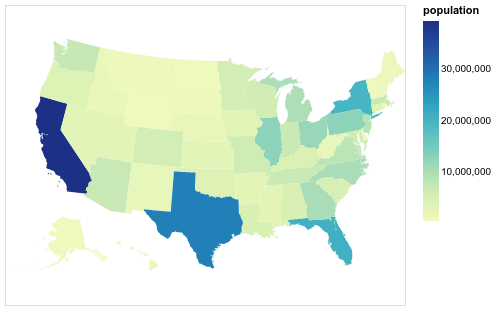

In [12]:
(alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    tooltip=['state:N', 'population:Q'])
.project(type='albersUsa'))

We could add a selection do this map,
the same way we learned in last lecture.

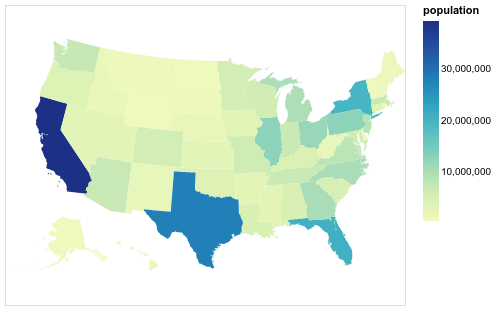

In [13]:
map_click = alt.selection_multi()

(alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

Let's have the selection do something meaningful.

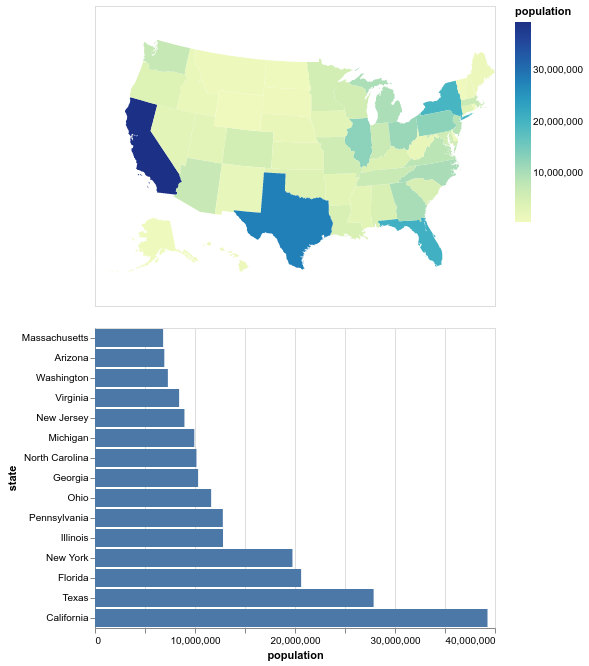

In [14]:
map_click = alt.selection_multi(fields=['state'])

choropleth = (alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

bars = (alt.Chart(state_pop.nlargest(15, 'population')).mark_bar().encode(
    x='population',
    y=alt.Y('state', sort='x'))
.transform_filter(map_click))

choropleth & bars

Let's make the bars clickable also and add a splash of color to them.
On the click even,
we will set the stroke color of both the bars and the map.

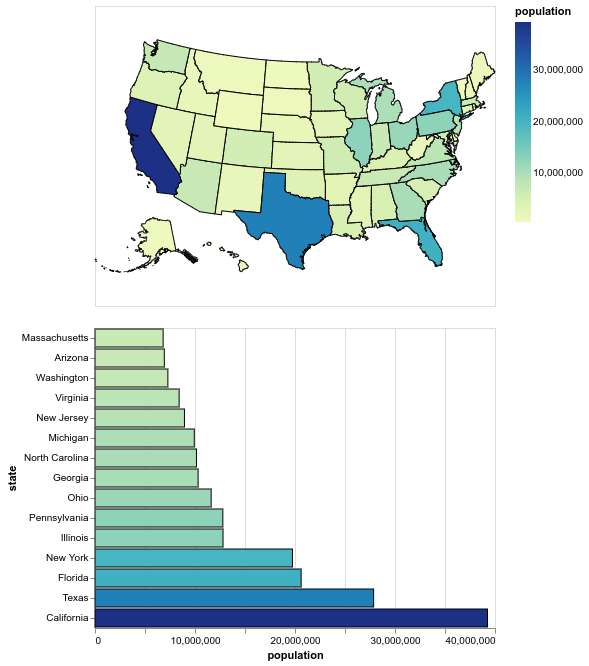

In [15]:
map_click = alt.selection_multi(fields=['state'])
bar_click = alt.selection_multi(fields=['state'])

choropleth = (alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff')),
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

bars = (alt.Chart(state_pop.nlargest(15, 'population')).mark_bar().encode(
    x='population',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff')),
    color='population',
    y=alt.Y('state', sort='x'))
.add_selection(bar_click)
.transform_filter(map_click))

choropleth & bars

One annoyance is that the outline of the map looks broken.
This is because the outilne of the non-selected regions is drawn in white,
and sometimes it is drawn on top of the black, covering it.
What we really want is transparency!
HTML colors can control transparency in the hex code directly,
by setting two extra characters at the end.
They range from `00` (transparent) to `ff` (opaque).

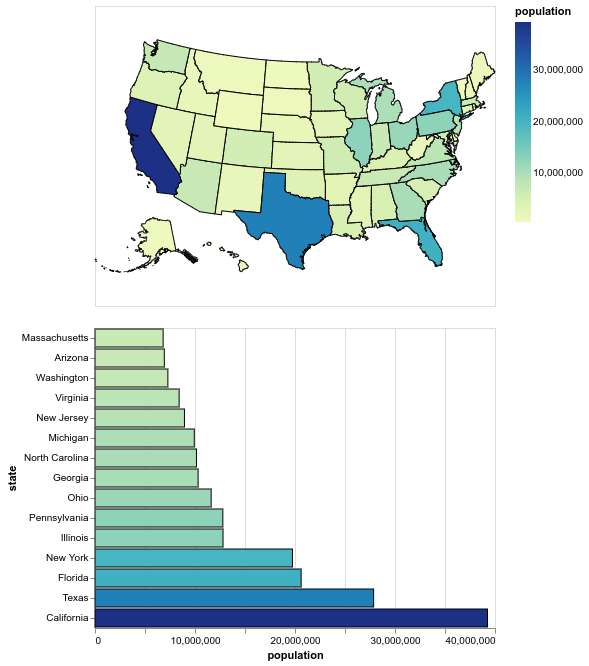

In [16]:
map_click = alt.selection_multi(fields=['state'])
bar_click = alt.selection_multi(fields=['state'])

choropleth = (alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

bars = (alt.Chart(state_pop.nlargest(15, 'population')).mark_bar().encode(
    x='population',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    color='population',
    y=alt.Y('state', sort='x'))
.add_selection(bar_click)
.transform_filter(map_click))

choropleth & bars

Now we can always see the outline!

Rather than clicking the bars, 
it would be cool if we could just hover over them 
to quicker see what is what in the plot.

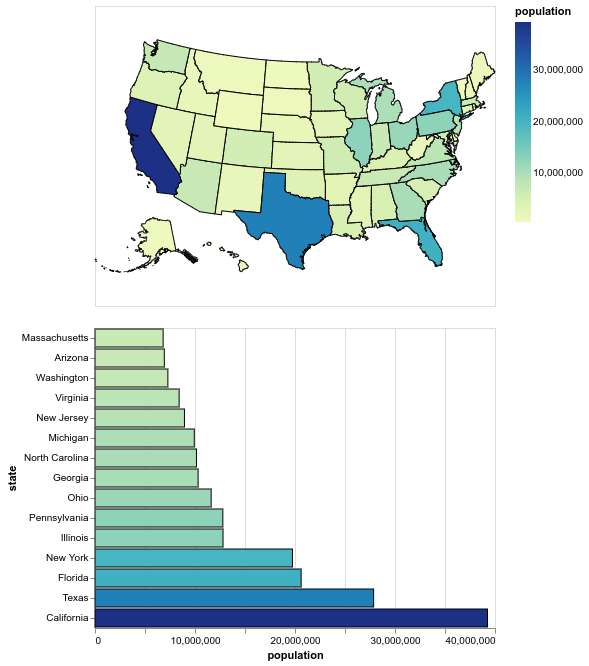

In [17]:
map_click = alt.selection_multi(fields=['state'])
bar_click = alt.selection_multi(fields=['state'], on='mouseover')

choropleth = (alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

bars = (alt.Chart(state_pop.nlargest(15, 'population')).mark_bar().encode(
    x='population',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    color='population',
    y=alt.Y('state', sort='x'))
.add_selection(bar_click)
.transform_filter(map_click))

choropleth & bars

Neat! 

However,
sometimes the map blinks and we see all borders, why?
This happens when we transition from one bar to another 
and might hit a space between where our selection is cleared
and everything is highlighted.
To ensure that something is always highlighted,
we can use the `nearest` parameter (on increase the bar width in this case).

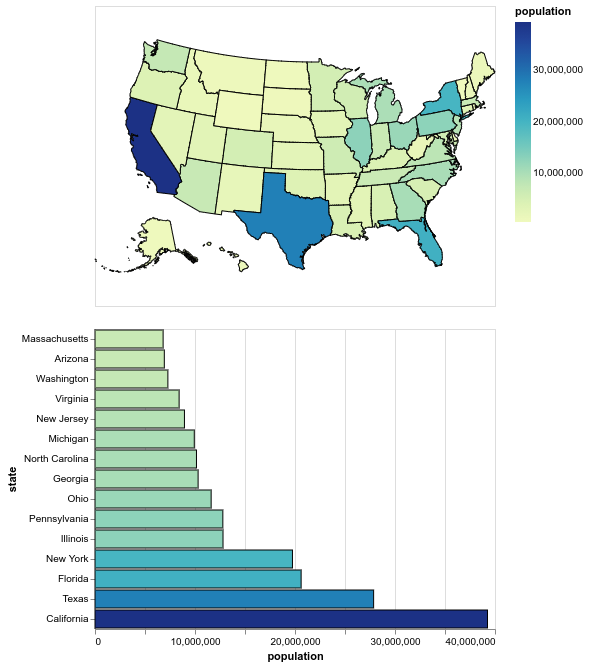

In [18]:
map_click = alt.selection_multi(fields=['state'])
bar_click = alt.selection_multi(fields=['state'], on='mouseover', nearest=True)

choropleth = (alt.Chart(state_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(state_pop, 'id', ['population', 'state']))
.encode(
    color='population:Q',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    opacity=alt.condition(map_click, alt.value(1), alt.value(0.2)),
    tooltip=['state:N', 'population:Q'])
.add_selection(map_click)
.project(type='albersUsa'))

bars = (alt.Chart(state_pop.nlargest(15, 'population')).mark_bar().encode(
    x='population',
    stroke=alt.condition(bar_click, alt.value('black'), alt.value('#ffffff00')),
    color='population',
    y=alt.Y('state', sort='x'))
.add_selection(bar_click)
.transform_filter(map_click))

choropleth & bars

## A note on choropleth interpretation

Although pretty,
choropleth maps have the disadvantage of hiding regions that have small land areas,
even when it is not relevant for the measurement that we are showing
(some small states might have really high population density,
but they would remain hidden in the choropleth map when we color by pop density).
In the chart below we can see the result from a recent american election (2012).
Just looking at this map,
do you think it was an even race?

Images from http://www-personal.umich.edu/~mejn/election/2012/

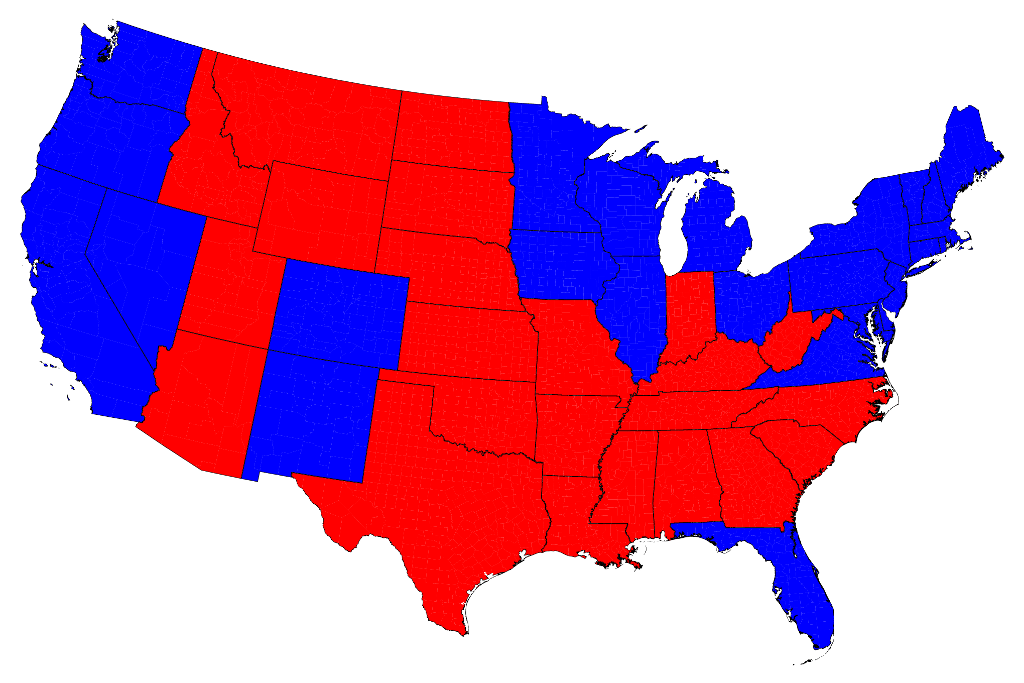

It looks like it was pretty tight,
but in fact it was a blowout.
This is Obama's 332-206 victory in 2012,
but the map does not show 62% blue region,
since it is scaled by land area,
rather than scaled by votes.
Maps scaled by other variables than area,
are called cartograms,
and there is one for the 2012 election.

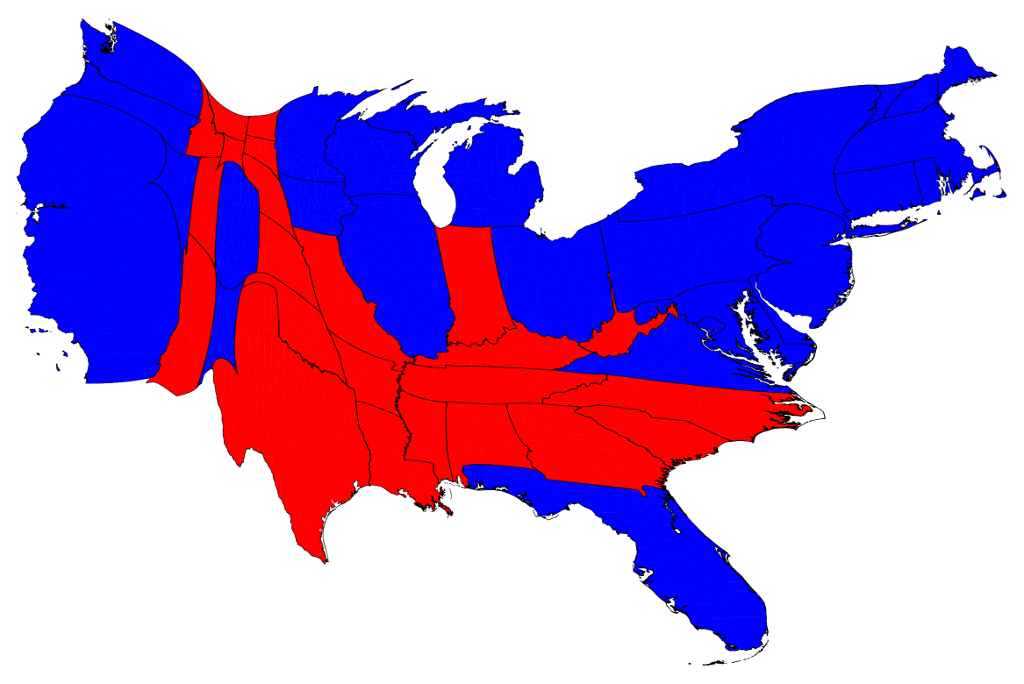

Now it looks more like an overwhelming blue victory.

Another way to create cartograms is by pixelation:

Images from https://www.ft.com/content/3685bf9e-a4cc-11e6-8b69-02899e8bd9d1

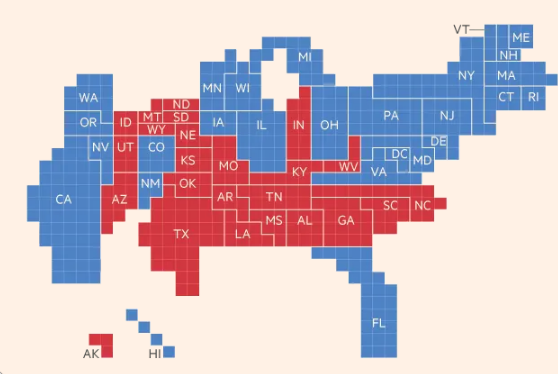

Or simply include a graphical mark such as a circle as the mean coordinates for each state
and scaling it proportionally.
This is a great visualization that is easy to interpret,
and it could be overlayed a map if needed
(sometimes it might still be hard to see big circles in small regions close together).

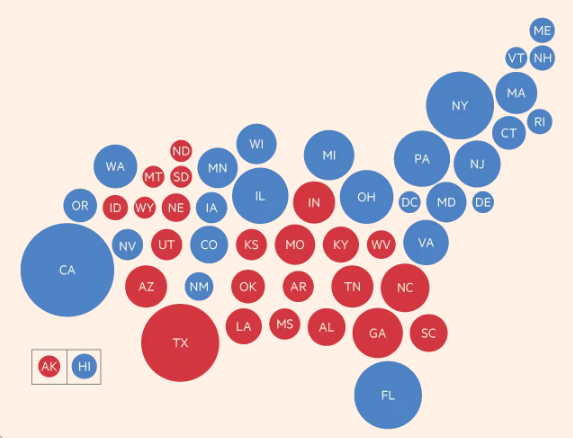

Altair has [a nice example of dots overlaying a geoshape](https://altair-viz.github.io/gallery/airports_count.html)
and a [cool interactive version showing all airport connections](https://altair-viz.github.io/gallery/airport_connections.html).
To make sure the marks line up with the underlying map
even when the projection changes,
we need to use the `longitude` and `latitude` parameters
rather than `x` and `y`
as seen in this example from the Altair docs

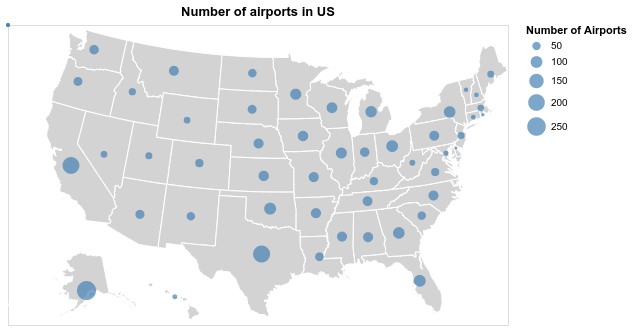

In [19]:
airports = data.airports.url
states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')

# This `transform_aggregate` step could have been performed in pandas instead
points = alt.Chart(airports).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='count()',
    groupby=['state']
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('count:Q', title='Number of Airports'),
    color=alt.value('steelblue'),
    tooltip=['state:N','count:Q']
).properties(
    title='Number of airports in US'
)

background + points

## A dataset with IDs for all the world's countries

The world geojson file contains the ID of each geometry,
similar to the US states data.
However,
we need a dataset that links these IDs to country names,
and there is none in the vega_datasets repo.
I have uploaded one to the `data` folder of the 532 github repo that you can use
([originally from here](https://raw.githubusercontent.com/KoGor/Map-Icons-Generator/master/data/world-110m-country-names.tsv)).

In [20]:
import pandas as pd

country_ids = pd.read_csv('../data/country-ids.csv') 
country_ids[:5]

,id,name
0,4,Afghanistan
1,8,Albania
2,12,Algeria
3,24,Angola
4,10,Antarctica


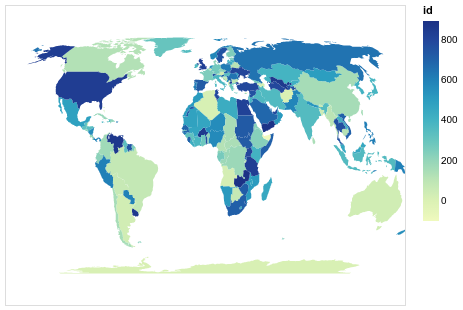

In [21]:
(alt.Chart(world_map).mark_geoshape().transform_lookup(
    lookup='id',
    from_=alt.LookupData(country_ids, 'id', ['name']))
 .encode(tooltip='name:O', color='id:Q')
 .project('equalEarth', scale=90))

Unless you have previous experience with geojson,
I advice against trying to merge geojson files
to create a custom file with only your countries of interest.
At least in my testing,
this was not very straightfoward,
and it is easier to just use one country with regions inside it,
or the world with countries instead of regions.
If you are interested in trying or looking at geojsons
for countries other than the US,
look into the following resources:

- https://github.com/topojson/world-atlas
- https://github.com/topojson/us-atlas
- https://geojson-maps.ash.ms/
- https://funkeinteraktiv.github.io/geo-data-merger/
- http://code.highcharts.com/mapdata/
- https://gadm.org/download_country_v3.html
- http://www.naturalearthdata.com/downloads/
- https://github.com/mapbox/geojson-merge
- https://mapshaper.org/

Lastly,
here is a cool visualization of all the countries in the world ordered by area: https://www.jasondavies.com/maps/countries-by-area/